In [1]:
import json
import os, sys

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

import support_functions as sf

In [2]:
MODEL_DIR = 'models/'
CALIB_DATA_DIR = 'calib_data/'
CALIB_MEAS_DIR = 'calib_meas/'
CALIB_HIST = True

with open(CALIB_DATA_DIR + 'parameters.json', 'r') as f:
    parameters = json.load(f)
P_NORM = parameters['p_norm']

In [27]:
for file in os.listdir(CALIB_MEAS_DIR):
    if not file.endswith('.json'):
        continue

    with open(CALIB_MEAS_DIR + file, 'r') as calib_file:
        calib_data = json.load( calib_file )

calib_data = np.asarray( calib_data['frames'] )
calib_data = calib_data[:,:400]
calib_data = calib_data.T / np.max(calib_data, axis=1)
calib_data = np.expand_dims(calib_data.T, -1)

/tmp/ipykernel_2943070/3593011455.py:10: RuntimeWarning: invalid value encountered in true_divide
  calib_data = calib_data.T / np.max(calib_data, axis=1)


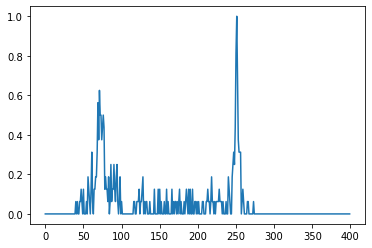

In [41]:
plt.plot( calib_data[90].flatten() )

## Load model

In [31]:
model = keras.models.load_model(MODEL_DIR + 'calibration_large.h5')

2022-05-02 20:17:25.738706: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-02 20:17:26.289001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4652 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [42]:
pred = model.predict( calib_data )

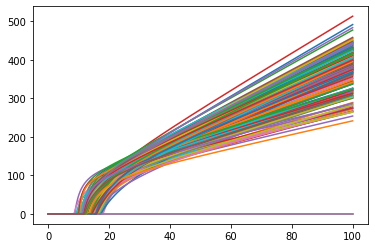

In [43]:
x = np.linspace(0, 100, 1000)
for pixel in range(256):
    # Prediction
    energy = sf.energy_to_tot(x, *pred[pixel] * P_NORM)
    plt.plot(x, energy)

In [44]:
np.diff([0] + energy).shape

(999,)

In [60]:
large_pixels = [pixel for pixel in range(256) if pixel % 16 not in [0, 1, 14, 15]]

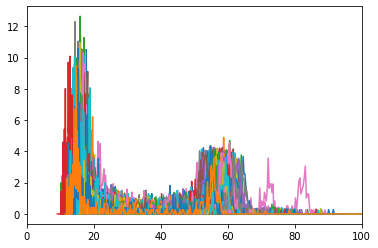

In [70]:
import scipy.interpolate
energy_true = np.linspace(0, 70, 100)
sum_spectrum = np.zeros(len(energy_true))

tot_x, tot_y = [], []
for pixel in large_pixels:
    cbd = calib_data[pixel].flatten().tolist()
    energy = sf.tot_to_energy(np.arange(400), *pred[pixel] * P_NORM).tolist()
    tot = (np.asarray(cbd) / np.diff([0] + energy)).tolist()
    
    # Sum spectrum
    f = scipy.interpolate.interp1d(energy, tot, bounds_error=False, fill_value=0)
    sum_spectrum += f(energy_true)
    
    tot_x += energy
    tot_y += tot
    plt.plot(energy, tot)
plt.xlim(0, 100)
plt.show()

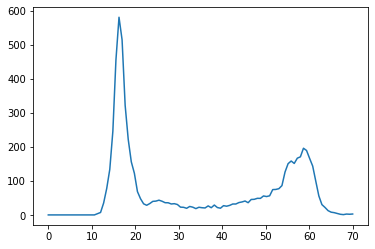

In [71]:
plt.plot(energy_true, sum_spectrum)

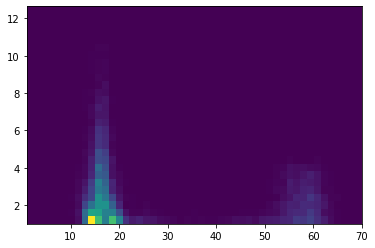

In [77]:
plt.hist2d(tot_x,
           tot_y,
           bins=[
               np.linspace(1, 70, 50),
               np.linspace(1, max(tot_y), 30)
           ]
          );